In [1]:
import sys
sys.path.append('/opt/code/face/dual_shot')
import numpy as np
import keras.layers as KL
from keras import Model
from dual_conf import current_config as conf
from net.dual_shot import test_net
from prepare_data.generator import gen_test,layer_strides,map_size,e_scale,ratio
import os
from prepare_data.model_target import apply_regress,init_anchors

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
weight_path = os.path.join(conf.output_dir, 'weights.h5')
print('loading trained model from:',weight_path)

Using TensorFlow backend.
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


using: resnet50 as the base model
loading trained model from: /opt/code/face/dual_shot/train_out/weights.h5


## load model 

In [2]:
net_in = KL.Input([640, 640, 3], name='image_array')
ss_cls, ss_regr = test_net(net_in)
model = Model(inputs=[net_in], outputs=[ss_cls, ss_regr])
model.summary()
model.load_weights(weight_path, by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_array (InputLayer)        (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 646, 646, 3)  0           image_array[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 320, 320, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 320, 320, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## load data

In [3]:
gen = gen_test(1, 'train')
x_val,y_val = next(gen)
print(x_val.shape,y_val)

Error bbox number to filter : 48,  bbox number: 159376
(1, 640, 640, 3) [[[  0.         482.31752608  22.87106405 520.36124608]
  [ 98.95850406 492.77954908 132.24675907 532.72545509]
  [189.31233908 469.00222407 218.79622209 510.85031608]
  [273.0085231  372.94183105 310.10115011 416.69210906]
  [350.04705612 420.49648106 380.48203212 464.24675907]
  [304.39459211 452.83364307 335.78066111 497.53501408]
  [462.27603014 454.73582907 493.66209915 492.77954908]
  [599.23342217 468.05113107 624.91293317 501.33938608]]]


## make prediction

In [4]:
def softmax(logit):
    assert len(logit.shape) == 2
    row_max = np.max(logit, axis=1)
    row_max = row_max[:, np.newaxis]
    logit = logit - row_max # make logit negtive to avoid infinity of e_x
    e_x = np.exp(logit)  
    row_sum = np.sum(e_x, axis=1)
    row_sum = row_sum[:, np.newaxis] 
    return e_x / row_sum

In [5]:
ss_cls,ss_regr= model.predict(x_val)
ss_cls,ss_regr= np.squeeze(ss_cls),np.squeeze(ss_regr)
ss_cls = softmax(ss_cls)
print(ss_cls.shape,ss_regr.shape)

(34125, 2) (34125, 4)


In [6]:
ss_cls

array([[9.8984373e-01, 1.0156226e-02],
       [9.9768472e-01, 2.3152935e-03],
       [9.9918419e-01, 8.1583118e-04],
       ...,
       [6.8550259e-01, 3.1449741e-01],
       [9.3368763e-01, 6.6312395e-02],
       [6.7567611e-01, 3.2432386e-01]], dtype=float32)

In [7]:
# ss_cls = np.random.rand(4,conf.num_anchor,2)
# ss_regr = np.random.rand(4,conf.num_anchor,4)
# print(ss_cls.shape,ss_regr.shape)

## init anchors

In [8]:
e_anchors = init_anchors(layer_strides, map_size, ratio, e_scale)
e_anchors.shape

(34125, 4)

## apply delta 

In [9]:
pred_box = apply_regress(ss_regr,e_anchors)
pred_box.shape

(34125, 4)

In [10]:
pred_box.shape

(34125, 4)

## top 5k

In [11]:
pred_score = ss_cls[...,1]

In [12]:
sort_inds = np.argsort(-pred_score)

In [13]:
sort_inds

array([30045, 29556, 30046, ..., 32278, 32198, 32158])

In [14]:
pred_score = pred_score[sort_inds]
pred_box = pred_box[sort_inds]

In [15]:
pred_score =pred_score[:5000]
pred_box =pred_box[:5000,:]
print(pred_score.shape,pred_box.shape)

(5000,) (5000, 4)


In [16]:
pred_score

array([0.9998636 , 0.9998449 , 0.99974316, ..., 0.11546729, 0.11545652,
       0.11541308], dtype=float32)

## nms

In [17]:
def bbox_vote(det):
    order = det[:, 4].ravel().argsort()[::-1]
    det = det[order, :]
    while det.shape[0] > 0:
        # IOU
        area = (det[:, 2] - det[:, 0] + 1) * (det[:, 3] - det[:, 1] + 1)
        xx1 = np.maximum(det[0, 0], det[:, 0])
        yy1 = np.maximum(det[0, 1], det[:, 1])
        xx2 = np.minimum(det[0, 2], det[:, 2])
        yy2 = np.minimum(det[0, 3], det[:, 3])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        o = inter / (area[0] + area[:] - inter)
        # get needed merge det and delete these det
        merge_index = np.where(o >= 0.3)[0]
        det_accu = det[merge_index, :]
        det = np.delete(det, merge_index, 0)
        if merge_index.shape[0] <= 1:
            continue
        det_accu[:, 0:4] = det_accu[:, 0:4] * np.tile(det_accu[:, -1:], (1, 4))
        max_score = np.max(det_accu[:, 4])
        det_accu_sum = np.zeros((1, 5))
        det_accu_sum[:, 0:4] = np.sum(det_accu[:, 0:4], axis=0) / np.sum(det_accu[:, -1:])
        det_accu_sum[:, 4] = max_score
        try:
            dets = np.row_stack((dets, det_accu_sum))
        except:
            dets = det_accu_sum
    dets = dets[dets[:, -1] > 0.5]  # ignore boxes with scores lower than 0.5
    dets = dets[0:750, :]
    return dets

In [18]:
pred_box.shape

(5000, 4)

In [19]:
det = np.concatenate([pred_box,np.expand_dims(pred_score,1)],axis=1)
final_box = bbox_vote(det)

In [20]:
final_box.shape

(160, 5)

In [21]:
final_box

array([[4.23352995e+02, 3.51363594e+02, 4.62824210e+02, 3.83334120e+02,
        9.99863625e-01],
       [3.69501229e+02, 2.76974432e+02, 4.20463729e+02, 3.13573089e+02,
        9.99844909e-01],
       [4.93065208e+02, 9.85636329e+01, 5.42309975e+02, 1.38332476e+02,
        9.99601424e-01],
       [4.75304371e+02, 1.99288321e+02, 5.13686053e+02, 2.24272177e+02,
        9.99572575e-01],
       [4.55023617e+02, 3.10316236e+02, 4.95299259e+02, 3.41068478e+02,
        9.98908043e-01],
       [4.69444092e+02, 6.00571111e+02, 4.99123834e+02, 6.21674707e+02,
        9.98346448e-01],
       [4.49792090e+02, 4.65581548e+02, 4.91096154e+02, 4.99110786e+02,
        9.98006761e-01],
       [4.88964840e+02, 3.91976328e+00, 5.26782595e+02, 2.98153125e+01,
        9.96252000e-01],
       [4.86891340e+02, 2.17749937e+01, 5.13005089e+02, 4.30894928e+01,
        9.94839489e-01],
       [4.90556715e+02, 2.02417388e+00, 5.11263893e+02, 1.55799449e+01,
        9.89169478e-01],
       [4.42081052e+02, 3.2874

In [22]:
final_box[:,-1]

array([0.99986362, 0.99984491, 0.99960142, 0.99957258, 0.99890804,
       0.99834645, 0.99800676, 0.996252  , 0.99483949, 0.98916948,
       0.98656994, 0.98543996, 0.9830845 , 0.98282558, 0.98053521,
       0.97917241, 0.97713864, 0.97705168, 0.96888655, 0.96077341,
       0.95936227, 0.9457981 , 0.9413352 , 0.94010293, 0.93807888,
       0.9348104 , 0.93359709, 0.92992049, 0.9265607 , 0.91093546,
       0.89812791, 0.89324933, 0.88856214, 0.8850258 , 0.88449872,
       0.88167918, 0.87407219, 0.87096059, 0.86967945, 0.86361057,
       0.85810375, 0.85663784, 0.85432291, 0.85427517, 0.85369503,
       0.85215455, 0.84979975, 0.83021545, 0.82964599, 0.82563078,
       0.82503331, 0.81588769, 0.80285144, 0.80245203, 0.80093694,
       0.8000052 , 0.78253478, 0.77614421, 0.77567565, 0.77205873,
       0.77166951, 0.76685035, 0.75836396, 0.75791115, 0.75555128,
       0.75294471, 0.74870247, 0.74869585, 0.74625516, 0.74186504,
       0.73999816, 0.73544079, 0.73320353, 0.72569835, 0.72352

## visualize

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_anchor(img_array, anchor_list):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img_array.astype(int))
    for a in anchor_list:
        y1,x1,y2,x2 = [int(i) for i in a]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


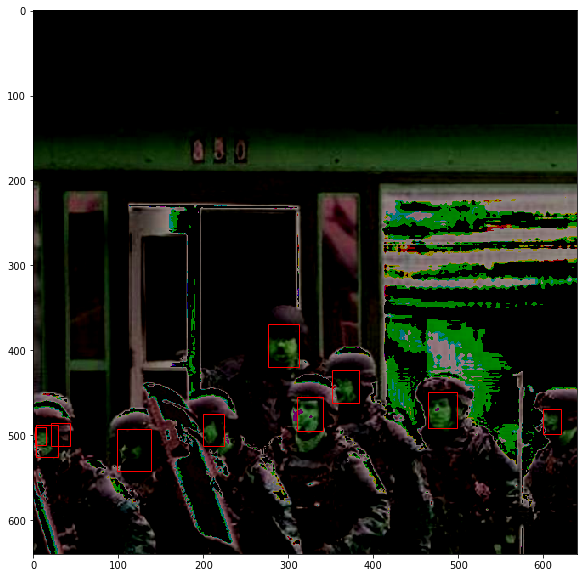

In [27]:
img_array = x_val[0]
anchor_list = final_box[:10,:4]
plot_anchor(img_array, anchor_list)